### Initial Data Set Up

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import ta
from ta import momentum
import ccxt
import hvplot
import hvplot.pandas
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from datetime import datetime, timedelta, timezone, date

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Get data from Binance exchange
exchange_class = getattr(ccxt,'binance') #note data pulling from Binance
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

### We set the ticker first and the data we require to be pulled from the API

In [2]:
#note - we will need toset the window to reflect long term indicators 

In [3]:
# Data function to get data depending on timeframe
def get_symbol_history(symbol,timeframe,start_date,end_date):
    
    if time_frame == '15m':
        # 1000 x 15m = 10 days
        freq = '10D'
    elif time_frame == '1h':
        # 1000 hours = 41 days
        freq = '41D'
    elif time_frame == '4h':
        # 1000 x 4h = 3 years
        freq = '166D'
    elif time_frame == '1d':
        # 1000 x 1d = 3 years
        freq = '3Y'
    
    period_starts = list(pd.date_range(start=start_date, end=end_date,freq=freq,tz='UTC').astype(np.int64))
    
    df = pd.DataFrame()
    for month in period_starts:
        since = int(month/1000000)
        new_df = pd.DataFrame(exchange.fetch_ohlcv(symbol, time_frame,since=since,limit=1000))
        if len(new_df) > 0:
            df = df.append(new_df)
    if len(df)>0:
        header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = header
    
    df = df.drop_duplicates() 
    df.reset_index(drop=True) 

    df.index = pd.to_datetime(df['Timestamp'],unit='ms')
    df.drop(columns = ['Timestamp'],inplace=True)
    
    return df

In [4]:
# Set data date range, timeframe and trading pair/ symbol
start_date = '16/07/2018' #3Y 'long term model' example
end_date = '15/07/2021'
time_frame = '1d' 
symbol = 'BTC/USDT'

raw_df = get_symbol_history(symbol,time_frame,start_date,end_date)

In [5]:
btc_df = raw_df.copy()

In [6]:
btc_df.tail()

Open      High       Low     Close        Volume
Timestamp                                                       
2021-07-18  31520.07  32435.00  31108.97  31778.56  35923.716186
2021-07-19  31778.57  31899.00  30407.44  30839.65  47340.468499
2021-07-20  30839.65  31063.07  29278.00  29790.35  61034.049017
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128
2021-07-22  32144.51  32376.78  31708.00  31953.56  20836.328235

In [7]:
# Drop NAs and calculate daily percent return
btc_df["period_return"] = btc_df["Close"].dropna().pct_change()
btc_df["target"] = btc_df["Close"].dropna().pct_change(7) #to capture change in last 24hrs or units of time (for short term 24hrs, long term 7 days)

# Display sample data
btc_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-12-31  3803.12  3810.00  3630.33  3702.90  29991.778350            NaN   
2019-01-01  3701.23  3810.16  3642.00  3797.14  23741.687033       0.025450   
2019-01-02  3796.45  3882.14  3750.45  3858.56  35156.463369       0.016175   
2019-01-03  3857.57  3862.74  3730.00  3766.78  29406.948359      -0.023786   
2019-01-04  3767.20  3823.64  3703.57  3792.01  29519.554671       0.006698   

            target  
Timestamp           
2018-12-31     NaN  
2019-01-01     NaN  
2019-01-02     NaN  
2019-01-03     NaN  
2019-01-04     NaN

### Moving Averages Indicator

In [8]:
# Set short and long windows
short_window = 3
long_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_close"] = btc_df["Close"].ewm(halflife=short_window).mean()
btc_df["slow_close"] = btc_df["Close"].ewm(halflife=long_window).mean()

# Crossover trading indicator
btc_df["crossover_long"] = np.where(btc_df["fast_close"] > btc_df["slow_close"], 1.0, 0.0)
btc_df["crossover_short"] = np.where(btc_df["fast_close"] < btc_df["slow_close"], -1.0, 0.0)
btc_df["crossover_signal"] = btc_df["crossover_long"] + btc_df["crossover_short"]
btc_df['Cross Entry/Exit'] = btc_df["crossover_signal"].diff()
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].replace(-2,-1).replace(2,1)

#btc_df.loc[btc_df['Cross Entry/Exit']==1]



In [9]:
btc_df['Cross Entry/Exit'] = btc_df['Cross Entry/Exit'].fillna(0)

In [10]:
cash = 10000
coins = 0
btc_df['Portfolio Cash'] = np.nan
btc_df['Coin Holdings'] = 0
for idx, row in btc_df.iterrows():
    
    btc_df.loc[idx,'Coin Holdings'] = coins
    btc_df.loc[idx,'Portfolio Cash'] = cash
    
    if row['Cross Entry/Exit']==1:
        # Open Buy
        coins = cash/row['Close']
        cash = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash
   
    elif row['Cross Entry/Exit']==-1:
        # Close buy
        cash = coins * row['Close']
        coins = 0
        btc_df.loc[idx,'Coin Holdings'] = coins
        btc_df.loc[idx,'Portfolio Cash'] = cash 
        
btc_df['Portfolio Holdings'] = btc_df['Coin Holdings'] * btc_df['Close']
btc_df['Portfolio Total'] = btc_df['Portfolio Holdings']  + btc_df['Portfolio Cash']
btc_df['Portfolio Returns'] = btc_df['Portfolio Total'].pct_change()
btc_df['Portolio Cumulative Returns'] = (1 + btc_df['Portfolio Returns']).cumprod() - 1


#btc_df.to_csv('test.csv')

In [71]:
btc_df.tail()

Open      High       Low     Close        Volume  \
Timestamp                                                          
2021-07-18  31520.07  32435.00  31108.97  31778.56  35923.716186   
2021-07-19  31778.57  31899.00  30407.44  30839.65  47340.468499   
2021-07-20  30839.65  31063.07  29278.00  29790.35  61034.049017   
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128   
2021-07-22  32144.51  32376.78  31708.00  31953.56  20836.328235   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2021-07-18       0.008201 -0.072402  32335.313542  33882.287018   
2021-07-19      -0.029545 -0.067912  32026.758940  33678.530719   
2021-07-20      -0.034024 -0.089809  31565.388952  33418.150888   
2021-07-21       0.079024 -0.020582  31684.861320  33332.858968   
2021-07-22      -0.005940  0.002307  31740.293716  33240.491442   

            crossover_long  ...  vol_trend_short  vol_trend_signal  \
Timestamp                   ...                                      
2021-07-18             0.0  ...              0.0               1.0   
2021-07-19             0.0  ...              0.0               1.0   
2021-07-20             0.0  ...              0.0               1.0   
2021-07-21             0.0  ...             -1.0              -1.0   
2021-07-22             0.0  ...             -1.0              -1.0   

            bollinger_mid_band  bollinger_std  bollinger_upper_band  \
Timestamp                                                             
2021-07-18          33481.4090    1252.383053          34733.792053   
2021-07-19          33227.8050    1247.881016          34475.686016   
2021-07-20          32965.0725    1390.196228          34355.268728   
2021-07-21          32897.0635    1395.668049          34292.731549   
2021-07-22          32805.4140    1394.366801          34199.780801   

            bollinger_lower_band  bollinger_long  bollinger_short  \
Timestamp                                                           
2021-07-18          32229.025947             1.0              0.0   
2021-07-19          31979.923984             1.0              0.0   
2021-07-20          31574.876272             1.0              0.0   
2021-07-21          31501.395451             0.0              0.0   
2021-07-22          31411.047199             0.0              0.0   

            bollinger_signal        rsi  
Timestamp                                
2021-07-18               1.0  40.901212  
2021-07-19               1.0  37.607169  
2021-07-20               1.0  34.284052  
2021-07-21               0.0  45.845901  
2021-07-22               0.0  45.151993  

[5 rows x 36 columns]

<AxesSubplot:xlabel='Timestamp'>

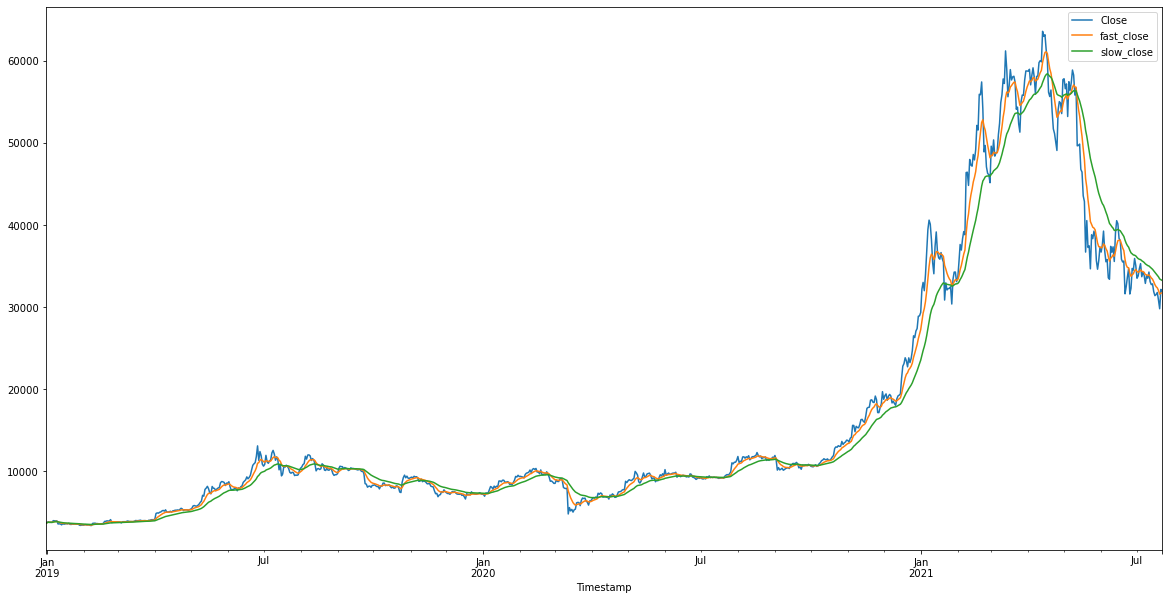

In [12]:
# Plot EMA of BTC/USD closing prices
btc_df[["Close", "fast_close", "slow_close"]].plot(figsize=(20,10))

In [13]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Cross Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Cross Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['fast_close', 'slow_close']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

In [14]:
# Plot EMA of BTC/USD daily return volatility
btc_df[['Portfolio Holdings','Portfolio Cash',"Portfolio Total"]].hvplot()

:NdOverlay   [Variable]
   :Curve   [Timestamp]   (value)

In [79]:
#btc_df['Portfolio Total'].list[-1]
#Retun last value 


AttributeError: 'Series' object has no attribute 'list'

### Simple Moving Average

In [15]:
short_window = 7
long_window = 30

btc_df['ma_short'] = btc_df['Close'].rolling(window=short_window).mean()
btc_df['ma_long'] = btc_df['Close'].rolling(window=long_window).mean()

btc_df['ma_signal'] = 0
btc_df['ma_signal'] = np.where(btc_df['ma_short']>btc_df['ma_long'],1,0)
btc_df['Entry/Exit'] = btc_df['ma_signal'].diff()


In [16]:
# Visualize exit position relative to Close price
exit = btc_df[btc_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(color='red',marker='v',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize entry position relative to Close price
entry = btc_df[btc_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(color='green',marker='^',size=200,legend=False,ylabel='Price in $',width=1000,height=400)

# Visualize Close price for the investment
price = btc_df[['Close']].hvplot(line_color='lightgray',ylabel='Price in $',width=1000,height=400)

# Visualize moving averages
moving_avgs = btc_df[['ma_short', 'ma_long']].hvplot(ylabel='Price in $',width=1000,height=400)

# Overlay plots
entry_exit_plot = price * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Timestamp]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Timestamp]   (value)
   .Scatter.Close.I  :Scatter   [Timestamp]   (Close)
   .Scatter.Close.II :Scatter   [Timestamp]   (Close)

<AxesSubplot:xlabel='Timestamp'>

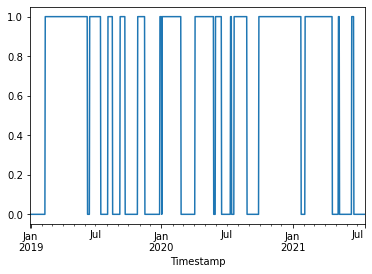

In [17]:
# Showing Bitcoin position at any time
btc_df['Entry/Exit'].cumsum().plot()

In [18]:
# Copy Porfolio holdings code from Moving Average as above with porfolio graphs and last port value 



Open      High       Low     Close        Volume  \
Timestamp                                                          
2021-07-18  31520.07  32435.00  31108.97  31778.56  35923.716186   
2021-07-19  31778.57  31899.00  30407.44  30839.65  47340.468499   
2021-07-20  30839.65  31063.07  29278.00  29790.35  61034.049017   
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128   
2021-07-22  32144.51  32376.78  31708.00  31953.56  20836.328235   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2021-07-18       0.008201 -0.072402  32335.313542  33882.287018   
2021-07-19      -0.029545 -0.067912  32026.758940  33678.530719   
2021-07-20      -0.034024 -0.089809  31565.388952  33418.150888   
2021-07-21       0.079024 -0.020582  31684.861320  33332.858968   
2021-07-22      -0.005940  0.002307  31740.293716  33240.491442   

            crossover_long  ...  Portfolio Cash  Coin Holdings  \
Timestamp                   ...                                  
2021-07-18             0.0  ...        34713.12            0.0   
2021-07-19             0.0  ...        34713.12            0.0   
2021-07-20             0.0  ...        34713.12            0.0   
2021-07-21             0.0  ...        34713.12            0.0   
2021-07-22             0.0  ...        34713.12            0.0   

            Portfolio Holdings  Portfolio Total  Portfolio Returns  \
Timestamp                                                            
2021-07-18                 0.0         34713.12                0.0   
2021-07-19                 0.0         34713.12                0.0   
2021-07-20                 0.0         34713.12                0.0   
2021-07-21                 0.0         34713.12                0.0   
2021-07-22                 0.0         34713.12                0.0   

            Portolio Cumulative Returns      ma_short       ma_long  \
Timestamp                                                             
2021-07-18                     2.471312  32171.274286  33541.168000   
2021-07-19                     2.471312  31850.277143  33386.365667   
2021-07-20                     2.471312  31430.360000  33192.705333   
2021-07-21                     2.471312  31333.858571  33210.558000   
2021-07-22                     2.471312  31344.367143  33192.024667   

            ma_signal  Entry/Exit  
Timestamp                          
2021-07-18          0         0.0  
2021-07-19          0         0.0  
2021-07-20          0         0.0  
2021-07-21          0         0.0  
2021-07-22          0         0.0  

[5 rows x 23 columns]

In [19]:
# Plot EMA of BTC/USD daily return 
btc_df[['Portfolio Total']].hvplot()

:Curve   [Timestamp]   (Portfolio Total)

### Volatility Indicator

In [20]:
# Set short and long volatility windows
short_vol_window = 3
long_vol_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_vol"] = btc_df["period_return"].ewm(halflife=short_vol_window).std()
btc_df["slow_vol"] = btc_df["period_return"].ewm(halflife=long_vol_window).std()

# Crossover trading signal
btc_df["vol_trend_long"] = np.where(btc_df["fast_vol"] < btc_df["slow_vol"], 1.0, 0.0)
btc_df["vol_trend_short"] = np.where(btc_df["fast_vol"] > btc_df["slow_vol"], -1.0, 0.0) 
btc_df["vol_trend_signal"] = btc_df["vol_trend_long"] + btc_df["vol_trend_short"]

btc_df

Open      High       Low     Close        Volume  \
Timestamp                                                          
2018-12-31   3803.12   3810.00   3630.33   3702.90  29991.778350   
2019-01-01   3701.23   3810.16   3642.00   3797.14  23741.687033   
2019-01-02   3796.45   3882.14   3750.45   3858.56  35156.463369   
2019-01-03   3857.57   3862.74   3730.00   3766.78  29406.948359   
2019-01-04   3767.20   3823.64   3703.57   3792.01  29519.554671   
...              ...       ...       ...       ...           ...   
2021-07-18  31520.07  32435.00  31108.97  31778.56  35923.716186   
2021-07-19  31778.57  31899.00  30407.44  30839.65  47340.468499   
2021-07-20  30839.65  31063.07  29278.00  29790.35  61034.049017   
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128   
2021-07-22  32144.51  32376.78  31708.00  31953.56  20836.328235   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2018-12-31            NaN       NaN   3702.900000   3702.900000   
2019-01-01       0.025450       NaN   3755.439428   3751.652401   
2019-01-02       0.016175       NaN   3797.986868   3789.784883   
2019-01-03      -0.023786       NaN   3787.312967   3783.422624   
2019-01-04       0.006698       NaN   3788.727518   3785.386039   
...                   ...       ...           ...           ...   
2021-07-18       0.008201 -0.072402  32335.313542  33882.287018   
2021-07-19      -0.029545 -0.067912  32026.758940  33678.530719   
2021-07-20      -0.034024 -0.089809  31565.388952  33418.150888   
2021-07-21       0.079024 -0.020582  31684.861320  33332.858968   
2021-07-22      -0.005940  0.002307  31740.293716  33240.491442   

            crossover_long  ...  Portolio Cumulative Returns      ma_short  \
Timestamp                   ...                                              
2018-12-31             0.0  ...                          NaN           NaN   
2019-01-01             1.0  ...                          NaN           NaN   
2019-01-02             1.0  ...                     0.000000           NaN   
2019-01-03             1.0  ...                     0.000000           NaN   
2019-01-04             1.0  ...                     0.000000           NaN   
...                    ...  ...                          ...           ...   
2021-07-18             0.0  ...                     2.471312  32171.274286   
2021-07-19             0.0  ...                     2.471312  31850.277143   
2021-07-20             0.0  ...                     2.471312  31430.360000   
2021-07-21             0.0  ...                     2.471312  31333.858571   
2021-07-22             0.0  ...                     2.471312  31344.367143   

                 ma_long  ma_signal  Entry/Exit  fast_vol  slow_vol  \
Timestamp                                                             
2018-12-31           NaN          0         NaN       NaN       NaN   
2019-01-01           NaN          0         0.0       NaN       NaN   
2019-01-02           NaN          0         0.0  0.006558  0.006558   
2019-01-03           NaN          0         0.0  0.027158  0.026487   
2019-01-04           NaN          0         0.0  0.020970  0.021267   
...                  ...        ...         ...       ...       ...   
2021-07-18  33541.168000          0         0.0  0.019024  0.033522   
2021-07-19  33386.365667          0         0.0  0.020146  0.033036   
2021-07-20  33192.705333          0         0.0  0.020830  0.032723   
2021-07-21  33210.558000          0         0.0  0.044310  0.038510   
2021-07-22  33192.024667          0         0.0  0.039744  0.037214   

            vol_trend_long  vol_trend_short  vol_trend_signal  
Timestamp                                                      
2018-12-31             0.0              0.0               0.0  
2019-01-01             0.0              0.0               0.0  
2019-01-02             0.0             -1.0              -1.0  


<AxesSubplot:xlabel='Timestamp'>

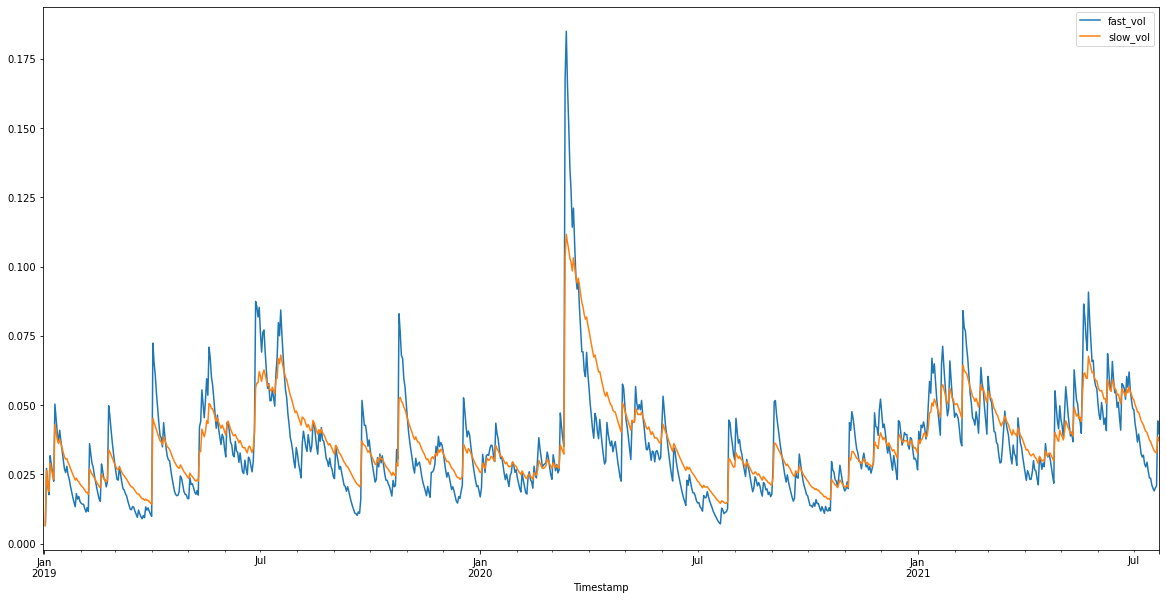

In [21]:
# Plot EMA of BTC/USD daily return volatility
btc_df[["fast_vol", "slow_vol"]].plot(figsize=(20,10))

In [ ]:
# copy porfolio stuff as above 

### Bollinger Bands Indicator

In [22]:
# Set bollinger band window
bollinger_window = 20

# Rolling mean and standard deviation
btc_df["bollinger_mid_band"] = btc_df["Close"].rolling(window=bollinger_window).mean()
btc_df["bollinger_std"] = btc_df["Close"].rolling(window=20).std()

# Upper and lowers bands of bollinger band
btc_df["bollinger_upper_band"]  = btc_df["bollinger_mid_band"] + (btc_df["bollinger_std"] * 1)
btc_df["bollinger_lower_band"]  = btc_df["bollinger_mid_band"] - (btc_df["bollinger_std"] * 1)

# Bollinger band trading signal
btc_df["bollinger_long"] = np.where(btc_df["Close"] < btc_df["bollinger_lower_band"], 1.0, 0.0)
btc_df["bollinger_short"] = np.where(btc_df["Close"] > btc_df["bollinger_upper_band"], -1.0, 0.0)
btc_df["bollinger_signal"] = btc_df["bollinger_long"] + btc_df["bollinger_short"]

btc_df

Open      High       Low     Close        Volume  \
Timestamp                                                          
2018-12-31   3803.12   3810.00   3630.33   3702.90  29991.778350   
2019-01-01   3701.23   3810.16   3642.00   3797.14  23741.687033   
2019-01-02   3796.45   3882.14   3750.45   3858.56  35156.463369   
2019-01-03   3857.57   3862.74   3730.00   3766.78  29406.948359   
2019-01-04   3767.20   3823.64   3703.57   3792.01  29519.554671   
...              ...       ...       ...       ...           ...   
2021-07-18  31520.07  32435.00  31108.97  31778.56  35923.716186   
2021-07-19  31778.57  31899.00  30407.44  30839.65  47340.468499   
2021-07-20  30839.65  31063.07  29278.00  29790.35  61034.049017   
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128   
2021-07-22  32144.51  32376.78  31708.00  31953.56  20836.328235   

            period_return    target    fast_close    slow_close  \
Timestamp                                                         
2018-12-31            NaN       NaN   3702.900000   3702.900000   
2019-01-01       0.025450       NaN   3755.439428   3751.652401   
2019-01-02       0.016175       NaN   3797.986868   3789.784883   
2019-01-03      -0.023786       NaN   3787.312967   3783.422624   
2019-01-04       0.006698       NaN   3788.727518   3785.386039   
...                   ...       ...           ...           ...   
2021-07-18       0.008201 -0.072402  32335.313542  33882.287018   
2021-07-19      -0.029545 -0.067912  32026.758940  33678.530719   
2021-07-20      -0.034024 -0.089809  31565.388952  33418.150888   
2021-07-21       0.079024 -0.020582  31684.861320  33332.858968   
2021-07-22      -0.005940  0.002307  31740.293716  33240.491442   

            crossover_long  ...  vol_trend_long  vol_trend_short  \
Timestamp                   ...                                    
2018-12-31             0.0  ...             0.0              0.0   
2019-01-01             1.0  ...             0.0              0.0   
2019-01-02             1.0  ...             0.0             -1.0   
2019-01-03             1.0  ...             0.0             -1.0   
2019-01-04             1.0  ...             1.0              0.0   
...                    ...  ...             ...              ...   
2021-07-18             0.0  ...             1.0              0.0   
2021-07-19             0.0  ...             1.0              0.0   
2021-07-20             0.0  ...             1.0              0.0   
2021-07-21             0.0  ...             0.0             -1.0   
2021-07-22             0.0  ...             0.0             -1.0   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2018-12-31               0.0                 NaN            NaN   
2019-01-01               0.0                 NaN            NaN   
2019-01-02              -1.0                 NaN            NaN   
2019-01-03              -1.0                 NaN            NaN   
2019-01-04               1.0                 NaN            NaN   
...                      ...                 ...            ...   
2021-07-18               1.0          33481.4090    1252.383053   
2021-07-19               1.0          33227.8050    1247.881016   
2021-07-20               1.0          32965.0725    1390.196228   
2021-07-21              -1.0          32897.0635    1395.668049   
2021-07-22              -1.0          32805.4140    1394.366801   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2018-12-31                   NaN                   NaN             0.0   
2019-01-01                   NaN                   NaN             0.0   
2019-01-02                   NaN                   NaN             0.0   
2019-01-03                   NaN                   NaN             0.0   
2019-01-04                   NaN                   NaN    

<AxesSubplot:xlabel='Timestamp'>

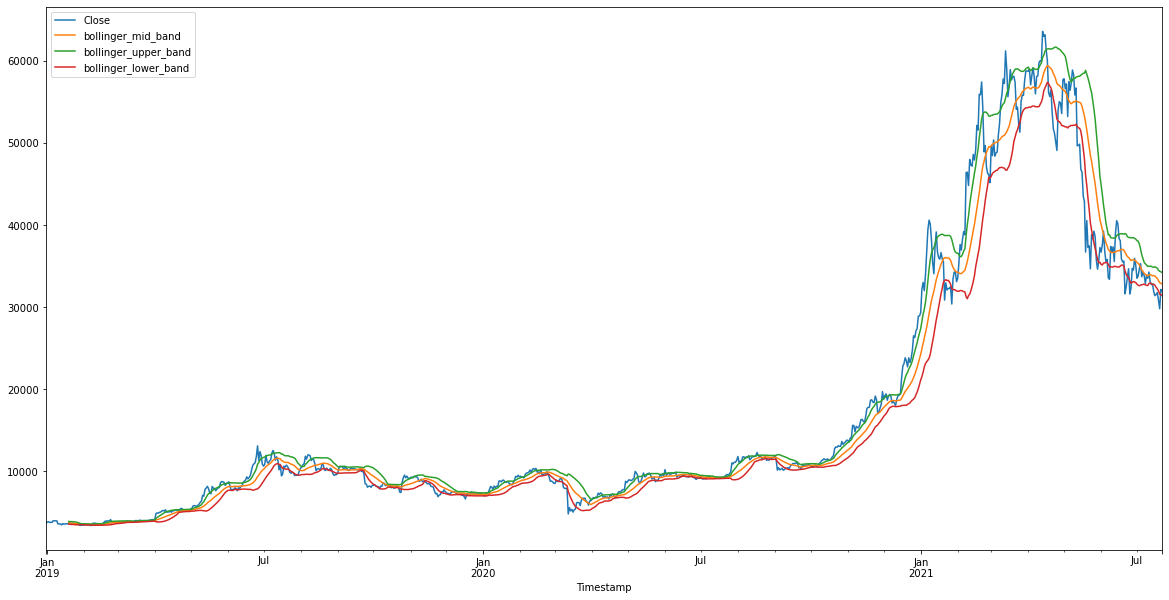

In [23]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[["Close","bollinger_mid_band","bollinger_upper_band","bollinger_lower_band"]].plot(figsize=(20,10))

In [ ]:
# Copy portfolio stuff as above 

### RSI Indicator

In [24]:
# Set up RSI Indicator for Random Forest - using btc_df
btc_df['rsi'] = momentum.RSIIndicator(btc_df['Close'],window=14).rsi()

In [80]:
btc_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2018-12-31  3803.12  3810.00  3630.33  3702.90  29991.778350            NaN   
2019-01-01  3701.23  3810.16  3642.00  3797.14  23741.687033       0.025450   
2019-01-02  3796.45  3882.14  3750.45  3858.56  35156.463369       0.016175   
2019-01-03  3857.57  3862.74  3730.00  3766.78  29406.948359      -0.023786   
2019-01-04  3767.20  3823.64  3703.57  3792.01  29519.554671       0.006698   

            target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                     ...   
2018-12-31     NaN  3702.900000  3702.900000             0.0  ...   
2019-01-01     NaN  3755.439428  3751.652401             1.0  ...   
2019-01-02     NaN  3797.986868  3789.784883             1.0  ...   
2019-01-03     NaN  3787.312967  3783.422624             1.0  ...   
2019-01-04     NaN  3788.727518  3785.386039             1.0  ...   

            vol_trend_short  vol_trend_signal  bollinger_mid_band  \
Timestamp                                                           
2018-12-31              0.0               0.0                 NaN   
2019-01-01              0.0               0.0                 NaN   
2019-01-02             -1.0              -1.0                 NaN   
2019-01-03             -1.0              -1.0                 NaN   
2019-01-04              0.0               1.0                 NaN   

            bollinger_std  bollinger_upper_band  bollinger_lower_band  \
Timestamp                                                               
2018-12-31            NaN                   NaN                   NaN   
2019-01-01            NaN                   NaN                   NaN   
2019-01-02            NaN                   NaN                   NaN   
2019-01-03            NaN                   NaN                   NaN   
2019-01-04            NaN                   NaN                   NaN   

            bollinger_long  bollinger_short  bollinger_signal  rsi  
Timestamp                                                           
2018-12-31             0.0              0.0               0.0  NaN  
2019-01-01             0.0              0.0               0.0  NaN  
2019-01-02             0.0              0.0               0.0  NaN  
2019-01-03             0.0              0.0               0.0  NaN  
2019-01-04             0.0              0.0               0.0  NaN  

[5 rows x 36 columns]

In [26]:
# note from below is using raw_df same as btc_df but copied for evaluating this indicator/ signal
df = raw_df.copy()

df['rsi'] = momentum.RSIIndicator(df['Close'],window=14).rsi()

df['position'] = 0
pos = 0

for idx,row in df.iterrows():
    
    rsi = row['rsi']
    
    if rsi < 20:
        # Opening Long
        df.loc[idx,'position'] = 1
    elif rsi > 80:
        # Opening Short
        df.loc[idx,'position'] = -1
        
    elif rsi < 60 and pos == - 1:
        # Closing Short
        df.loc[idx,'position'] = 0
        
    elif rsi > 40 and pos == 1:
        # Closing Long
        df.loc[idx,'position'] = 0
    else:
        df.loc[idx,'position'] = pos
        
    # Update my position for next iteration of loop
    pos = df.loc[idx,'position']
        
df['Entry/Exit'] = df['position'].diff(1).fillna(0)

In [27]:
#pull in the porfolio code as above 

Open      High       Low     Close        Volume        rsi  \
Timestamp                                                                     
2021-07-18  31520.07  32435.00  31108.97  31778.56  35923.716186  40.901212   
2021-07-19  31778.57  31899.00  30407.44  30839.65  47340.468499  37.607169   
2021-07-20  30839.65  31063.07  29278.00  29790.35  61034.049017  34.284052   
2021-07-21  29790.34  32858.00  29482.61  32144.51  82796.265128  45.845901   
2021-07-22  32144.51  32376.78  31708.00  31953.56  20836.328235  45.151993   

            position  Entry/Exit  Portfolio Holdings  Portfolio Cash  \
Timestamp                                                              
2021-07-18         0         0.0                 0.0        10324.14   
2021-07-19         0         0.0                 0.0        10324.14   
2021-07-20         0         0.0                 0.0        10324.14   
2021-07-21         0         0.0                 0.0        10324.14   
2021-07-22         0         0.0                 0.0        10324.14   

            Portfolio Total  Portfolio Returns  Portolio Cumulative Returns  
Timestamp                                                                    
2021-07-18         10324.14                0.0                     0.032414  
2021-07-19         10324.14                0.0                     0.032414  
2021-07-20         10324.14                0.0                     0.032414  
2021-07-21         10324.14                0.0                     0.032414  
2021-07-22         10324.14                0.0                     0.032414

In [28]:
def plot_strategy(df):
    # Visualize exit position relative to total portfolio value
    exit = df[df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
        color='red',
        legend=False,
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Visualize entry position relative to total portfolio value
    entry = df[df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
        color='green',
        legend=False,
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Visualize total portoflio value for the investment
    total_portfolio_value = df[['Portfolio Total']].hvplot(
        line_color='lightgray',
        ylabel='Total Portfolio Value',
        width=1000,
        height=400
    )

    # Overlay plots
    portfolio_entry_exit_plot = total_portfolio_value * entry * exit
    return portfolio_entry_exit_plot.opts(xaxis=None)


#use the graph as per previous models 

In [29]:
plot_strategy(df)

:Overlay
   .Curve.I                    :Curve   [Timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Timestamp]   (Portfolio Total)

# Trading Signals/ Indicators

In [36]:
trading_signals_df = btc_df.copy()

In [81]:
# Set x variable list of features
x_var_list = ["crossover_signal", "vol_trend_signal", "bollinger_signal", "rsi", "ma_signal"]

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

crossover_signal  vol_trend_signal  bollinger_signal        rsi  \
Timestamp                                                                     
2021-07-18              -1.0               1.0               1.0  39.547558   
2021-07-19              -1.0               1.0               1.0  40.901212   
2021-07-20              -1.0               1.0               1.0  37.607169   
2021-07-21              -1.0               1.0               1.0  34.284052   
2021-07-22              -1.0              -1.0               0.0  45.845901   

            ma_signal  
Timestamp              
2021-07-18          0  
2021-07-19          0  
2021-07-20          0  
2021-07-21          0  
2021-07-22          0

In [82]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

crossover_signal  vol_trend_signal  bollinger_signal        rsi  \
Timestamp                                                                     
2019-01-14               NaN               NaN               NaN        NaN   
2019-01-15              -1.0              -1.0               0.0  31.251957   
2019-01-16              -1.0              -1.0               0.0  43.590937   
2019-01-17              -1.0              -1.0               0.0  39.825111   
2019-01-18              -1.0               1.0               0.0  42.657991   

            ma_signal  
Timestamp              
2019-01-14        NaN  
2019-01-15        0.0  
2019-01-16        0.0  
2019-01-17        0.0  
2019-01-18        0.0

In [83]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-15  3626.08  3648.42  3516.62  3553.06  34137.997459      -0.020140   
2019-01-16  3553.06  3645.00  3543.51  3591.84  27480.179977       0.010915   
2019-01-17  3591.84  3634.70  3530.39  3616.21  29755.440838       0.006785   
2019-01-18  3613.32  3620.00  3565.75  3594.87  22713.446755      -0.005901   
2019-01-19  3594.87  3720.00  3594.23  3665.30  22171.578123       0.019592   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-15 -0.101658  3646.501673  3719.425552             0.0  ...   
2019-01-16 -0.094490  3634.998545  3707.082513             0.0  ...   
2019-01-17  0.008458  3631.060953  3698.545416             0.0  ...   
2019-01-18 -0.001788  3623.501024  3689.061406             0.0  ...   
2019-01-19  0.022932  3632.209853  3686.939765             0.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2019-01-15              -1.0                 NaN            NaN   
2019-01-16              -1.0                 NaN            NaN   
2019-01-17              -1.0                 NaN            NaN   
2019-01-18               1.0                 NaN            NaN   
2019-01-19               1.0            3723.384     159.052398   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2019-01-15                   NaN                   NaN             0.0   
2019-01-16                   NaN                   NaN             0.0   
2019-01-17                   NaN                   NaN             0.0   
2019-01-18                   NaN                   NaN             0.0   
2019-01-19           3882.436398           3564.331602             0.0   

            bollinger_short  bollinger_signal        rsi  Positive Return  
Timestamp                                                                  
2019-01-15              0.0               0.0  31.251957               -1  
2019-01-16              0.0               0.0  43.590937               -1  
2019-01-17              0.0               0.0  39.825111                0  
2019-01-18              0.0               0.0  42.657991                0  
2019-01-19              0.0               0.0  44.428497                0  

[5 rows x 37 columns]

### Classification (Random Forest)

In [91]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

Open     High      Low    Close        Volume  period_return  \
Timestamp                                                                     
2019-01-15  3626.08  3648.42  3516.62  3553.06  34137.997459      -0.020140   
2019-01-16  3553.06  3645.00  3543.51  3591.84  27480.179977       0.010915   
2019-01-17  3591.84  3634.70  3530.39  3616.21  29755.440838       0.006785   
2019-01-18  3613.32  3620.00  3565.75  3594.87  22713.446755      -0.005901   
2019-01-19  3594.87  3720.00  3594.23  3665.30  22171.578123       0.019592   

              target   fast_close   slow_close  crossover_long  ...  \
Timestamp                                                       ...   
2019-01-15 -0.101658  3646.501673  3719.425552             0.0  ...   
2019-01-16 -0.094490  3634.998545  3707.082513             0.0  ...   
2019-01-17  0.008458  3631.060953  3698.545416             0.0  ...   
2019-01-18 -0.001788  3623.501024  3689.061406             0.0  ...   
2019-01-19  0.022932  3632.209853  3686.939765             0.0  ...   

            vol_trend_signal  bollinger_mid_band  bollinger_std  \
Timestamp                                                         
2019-01-15              -1.0                 NaN            NaN   
2019-01-16              -1.0                 NaN            NaN   
2019-01-17              -1.0                 NaN            NaN   
2019-01-18               1.0                 NaN            NaN   
2019-01-19               1.0            3723.384     159.052398   

            bollinger_upper_band  bollinger_lower_band  bollinger_long  \
Timestamp                                                                
2019-01-15                   NaN                   NaN             0.0   
2019-01-16                   NaN                   NaN             0.0   
2019-01-17                   NaN                   NaN             0.0   
2019-01-18                   NaN                   NaN             0.0   
2019-01-19           3882.436398           3564.331602             0.0   

            bollinger_short  bollinger_signal        rsi  Positive Return  
Timestamp                                                                  
2019-01-15              0.0               0.0  31.251957              0.0  
2019-01-16              0.0               0.0  43.590937              0.0  
2019-01-17              0.0               0.0  39.825111              1.0  
2019-01-18              0.0               0.0  42.657991              0.0  
2019-01-19              0.0               0.0  44.428497              1.0  

[5 rows x 37 columns]

In [92]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [93]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    373
 1    346
-1    201
Name: Positive Return, dtype: int64

In [94]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-15
Training End: 2021-01-20 00:00:00
Testing Start: 2021-01-21 00:00:00
Testing End: 2021-07-22


In [95]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

crossover_signal  vol_trend_signal  bollinger_signal        rsi  \
Timestamp                                                                     
2021-01-16               1.0              -1.0              -1.0  69.443489   
2021-01-17               1.0              -1.0               0.0  61.625107   
2021-01-18               1.0              -1.0               0.0  59.385425   
2021-01-19               1.0              -1.0               0.0  58.872399   
2021-01-20               1.0               1.0               0.0  60.639113   

            ma_signal  
Timestamp              
2021-01-16        1.0  
2021-01-17        1.0  
2021-01-18        1.0  
2021-01-19        1.0  
2021-01-20        1.0

Timestamp
2021-01-16   -1
2021-01-17   -1
2021-01-18    0
2021-01-19    1
2021-01-20   -1
Name: Positive Return, dtype: int64

In [96]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

crossover_signal  vol_trend_signal  bollinger_signal        rsi  \
Timestamp                                                                     
2021-07-18              -1.0               1.0               1.0  38.862408   
2021-07-19              -1.0               1.0               1.0  39.547558   
2021-07-20              -1.0               1.0               1.0  40.901212   
2021-07-21              -1.0               1.0               1.0  37.607169   
2021-07-22              -1.0               1.0               1.0  34.284052   

            ma_signal  
Timestamp              
2021-07-18        0.0  
2021-07-19        0.0  
2021-07-20        0.0  
2021-07-21        0.0  
2021-07-22        0.0

Timestamp
2021-07-18   -1
2021-07-19   -1
2021-07-20   -1
2021-07-21    0
2021-07-22    0
Name: Positive Return, dtype: int64

In [97]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    101
 1     45
-1     37
Name: Predicted Value, dtype: int64

<AxesSubplot:>

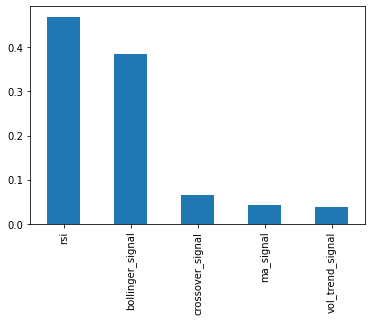

In [98]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [99]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [100]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([ 0,  0, -1, -1, -1, -1,  0,  0,  0,  0])

In [101]:
results["Predicted Value"].value_counts()

 0    101
 1     45
-1     37
Name: Predicted Value, dtype: int64

In [102]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

Positive Return  Predicted Value
Timestamp                                   
2021-01-21               -1                0
2021-01-22               -1                0
2021-01-23               -1               -1
2021-01-24               -1               -1
2021-01-25               -1               -1
2021-01-26               -1               -1
2021-01-27               -1                0
2021-01-28                1                0
2021-01-29                0                0
2021-01-30                1                0

<AxesSubplot:xlabel='Timestamp'>

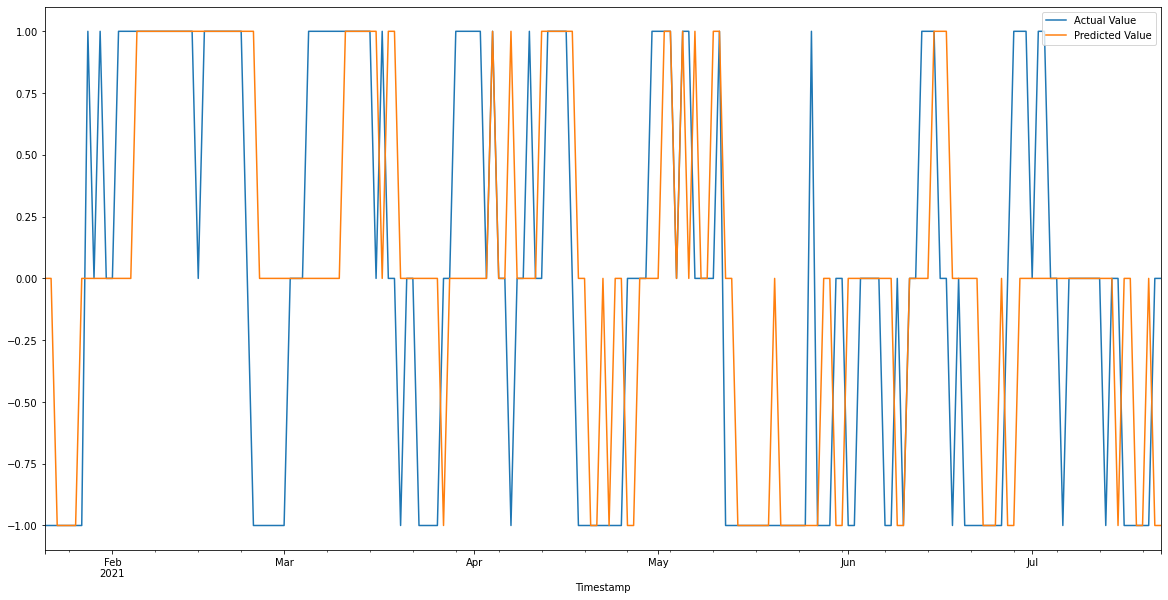

In [103]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

In [53]:
# Replace predicted values 0 to -1 to account for shorting
# results["Predicted Value"] = results["Predicted Value"].replace(0, -1)

# Display sample data
# results

### The Combined Model In Action (Results)

<AxesSubplot:xlabel='Timestamp'>

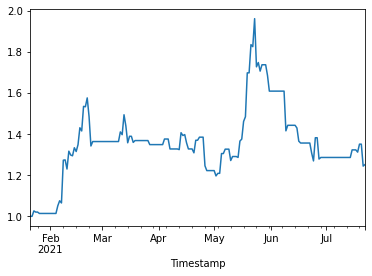

In [104]:
# Cumulative return of the model
results['Return'] = trading_signals_df['period_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

<AxesSubplot:xlabel='Timestamp'>

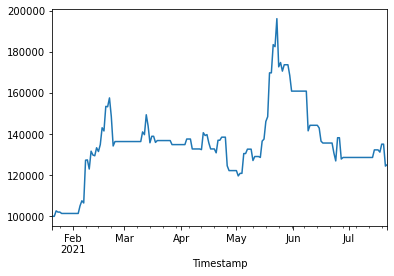

In [105]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

In [ ]:
# Need to spit out $ value for combined stategy to evalutae LT/ST models

### Return Groupings Assessment

In [56]:
# Set up copy of main df
group_df = btc_df.copy()

In [57]:
model.predict(X_test)

array([ 0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
        1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  0,  0, -1,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  1, -1,  0, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0, -1, -1,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,
       -1, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1, -1,  0])

In [58]:
# Assess the confidence in each prediction in the model
results['probability'] = model.predict_proba(X_test)[:,1]

In [59]:
# Set up code for confidence levels when the return is negative vs when positive
results['pos_neg_result'] = results['Predicted Value'] * results['probability']

In [60]:
results

Positive Return  Predicted Value  Actual Value    Return  \
Timestamp                                                              
2021-01-20               -1                0            -1 -0.011793   
2021-01-21               -1                0            -1 -0.130204   
2021-01-22               -1               -1            -1  0.067910   
2021-01-23               -1               -1            -1 -0.026322   
2021-01-24               -1               -1            -1  0.005671   
...                     ...              ...           ...       ...   
2021-07-18               -1               -1            -1  0.008201   
2021-07-19               -1                0            -1 -0.029545   
2021-07-20               -1               -1            -1 -0.034024   
2021-07-21                0               -1             0  0.079024   
2021-07-22                0                0             0 -0.005940   

            probability  pos_neg_result  
Timestamp                                
2021-01-20     0.675696        0.000000  
2021-01-21     0.647089        0.000000  
2021-01-22     0.285237       -0.285237  
2021-01-23     0.297925       -0.297925  
2021-01-24     0.325636       -0.325636  
...                 ...             ...  
2021-07-18     0.421651       -0.421651  
2021-07-19     0.761426        0.000000  
2021-07-20     0.286951       -0.286951  
2021-07-21     0.280478       -0.280478  
2021-07-22     0.547583        0.000000  

[184 rows x 6 columns]

In [61]:
results.groupby(by='Predicted Value').mean()

Positive Return  Actual Value    Return  probability  \
Predicted Value                                                         
-1                     -0.756757     -0.756757  0.005312     0.238205   
 0                     -0.066038     -0.066038 -0.003288     0.622789   
 1                      0.756098      0.756098  0.005799     0.232504   

                 pos_neg_result  
Predicted Value                  
-1                    -0.238205  
 0                     0.000000  
 1                     0.232504

In [62]:
# Looking at the results by a group (i.e. 5 in this case) and the count and mean return
results['probability_quantile'] = pd.qcut(results['probability'],5,duplicates='drop')
group_results = results.groupby('probability_quantile').agg(['count','mean'])[['Return']]
group_results

Return          
                      count      mean
probability_quantile                 
(0.0243, 0.209]          37  0.002224
(0.209, 0.418]           37  0.009292
(0.418, 0.562]           36  0.005008
(0.562, 0.679]           37 -0.000359
(0.679, 0.761]           37 -0.013711

<AxesSubplot:xlabel='probability_quantile'>

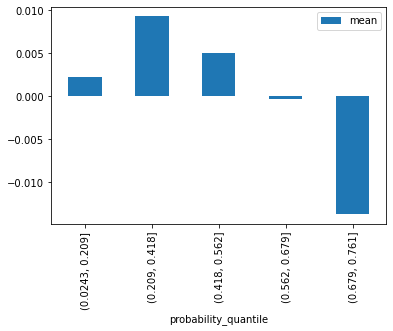

In [63]:
# Plot results - bar chart (mean)
plot_results = pd.DataFrame(group_results['Return']['mean'])
plot_results.plot.bar()

In [64]:
# Assess buy, hold, sell confidence levels
df = model.predict_proba(X_test)
df = pd.DataFrame(df)
df.columns=['-1','0','1']

Returns = []
for item in results['Return']:
    Returns.append(item)
    
df['Return'] = Returns

df.head(5)

-1         0         1    Return
0  0.142575  0.675696  0.181729 -0.011793
1  0.158628  0.647089  0.194282 -0.130204
2  0.687515  0.285237  0.027248  0.067910
3  0.673852  0.297925  0.028223 -0.026322
4  0.645487  0.325636  0.028877  0.005671

In [65]:
df = model.predict_proba(X_test)
df = pd.DataFrame(df)
df.columns=['-1','0','1']

Returns = []
for item in results['Return']:
    Returns.append(item)
    
df['Return'] = Returns

df_neg = pd.DataFrame(df)


del df_neg['0']
del df_neg['1']
df_neg['probability_quantile'] = pd.qcut(df_neg['-1'],5,duplicates='drop')
df_neg = df_neg.groupby('probability_quantile').agg(['count','mean'])[['Return']]
df_neg # i.e. to assess confidence when predicted it is -1, it actually is -1



Return          
                                  count      mean
probability_quantile                             
(0.00013999999999999993, 0.0314]     37  0.004904
(0.0314, 0.165]                      37 -0.011521
(0.165, 0.224]                       36 -0.006306
(0.224, 0.466]                       37  0.009760
(0.466, 0.907]                       37  0.005312

<AxesSubplot:xlabel='probability_quantile'>

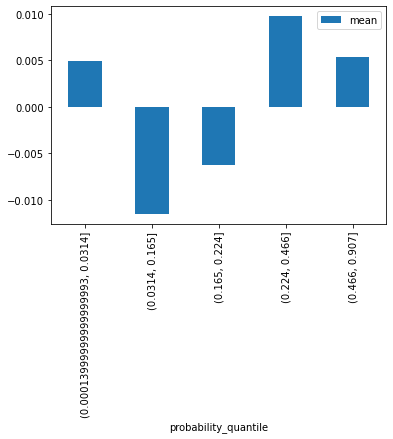

In [66]:
df_neg_plot = pd.DataFrame(df_neg['Return']['mean'])
df_neg_plot.plot.bar()

In [67]:
df = model.predict_proba(X_test)
df = pd.DataFrame(df)
df.columns=['-1','0','1']

Returns = []
for item in results['Return']:
    Returns.append(item)
    
df['Return'] = Returns

df_pos = pd.DataFrame(df)
del df_pos['-1']
del df_pos['0']
df_pos['probability_quantile'] = pd.qcut(df_pos['1'],5,duplicates='drop')
df_pos = df_pos.groupby('probability_quantile').agg(['count','mean'])[['Return']]
df_pos

Return          
                               count      mean
probability_quantile                          
(0.009899999999999999, 0.073]     37  0.008769
(0.073, 0.118]                    37 -0.005805
(0.118, 0.182]                    37 -0.007966
(0.182, 0.572]                    37 -0.000200
(0.572, 0.974]                    36  0.007730

<AxesSubplot:xlabel='probability_quantile'>

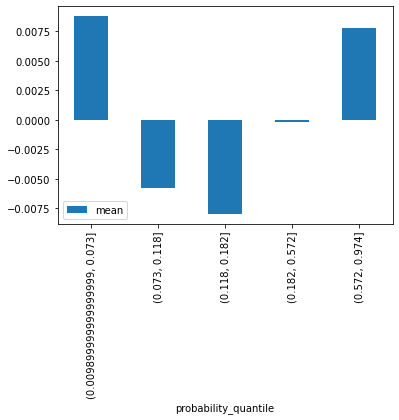

In [68]:
df_pos_plot = pd.DataFrame(df_pos['Return']['mean'])
df_pos_plot.plot.bar()

In [69]:
df = model.predict_proba(X_test)
df = pd.DataFrame(df)
df.columns=['-1','0','1']

Returns = []
for item in results['Return']:
    Returns.append(item)
    
df['Return'] = Returns

df_neutral = pd.DataFrame(df)
del df_neutral['-1']
del df_neutral['1']
df_neutral['probability_quantile'] = pd.qcut(df_neutral['0'],5,duplicates='drop')
df_neutral = df_neutral.groupby('probability_quantile').agg(['count','mean'])[['Return']]
df_neutral

Return          
                      count      mean
probability_quantile                 
(0.0243, 0.209]          37  0.002224
(0.209, 0.418]           37  0.009292
(0.418, 0.562]           36  0.005008
(0.562, 0.679]           37 -0.000359
(0.679, 0.761]           37 -0.013711

<AxesSubplot:xlabel='probability_quantile'>

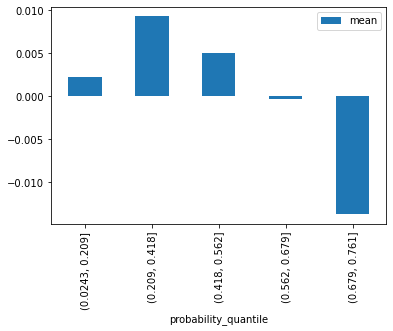

In [70]:
df_neutral_plot = pd.DataFrame(df_neutral['Return']['mean'])
df_neutral_plot.plot.bar()